We got inspiration from the following kaggle blog to build our model off of: https://www.kaggle.com/code/willkoehrsen/automated-model-tuning

In [ ]:
import pandas as pd
import numpy as np

import lightgbm as lgb

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns

N_FOLDS = 3
MAX_EVALS = 50

## Data Set-up

In [ ]:
features = pd.read_csv('data/application_train.csv')

In [ ]:
features = features.sample(n = 16000, random_state = 42)
features = features.select_dtypes('number')
labels = np.array(features['TARGET'].astype(np.int32)).reshape((-1, ))
features = features.drop(columns = ['TARGET', 'SK_ID_CURR'])
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 6000, random_state = 50)

In [ ]:
print("Training features shape: ", train_features.shape)
print("Testing features shape: ", test_features.shape)

Training features shape:  (10000, 104)
Testing features shape:  (6000, 104)


In [ ]:
train_set = lgb.Dataset(data = train_features, label = train_labels)
test_set = lgb.Dataset(data = test_features, label = test_labels)

In [ ]:
%%capture

model = lgb.LGBMClassifier()
default_params = model.get_params()

del default_params['n_estimators']

cv_results = lgb.cv(default_params, train_set, num_boost_round = 100, metrics = 'auc', nfold = N_FOLDS, seed = 42)

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
%%capture
model.n_estimators = len(cv_results['valid auc-mean'])

# Train and make predicions with model
model.fit(train_features, train_labels)
preds = model.predict_proba(test_features)[:, 1]

# Data Exploration

In [ ]:
train_features.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
158978,1,90000.0,824823.0,24246.0,688500.0,0.018801,-11490,-2416,-5034.0,-3168,...,0,0,0,0,0.0,0.0,1.0,0.0,2.0,0.0
171580,0,90000.0,225000.0,12204.0,225000.0,0.010032,-9275,-862,-463.0,-888,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,5.0
132315,0,112500.0,906615.0,30091.5,688500.0,0.005313,-17486,-1712,-4851.0,-1040,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0
177084,0,67500.0,148365.0,13738.5,135000.0,0.010147,-18047,-2231,-10232.0,-1601,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
238658,2,742500.0,849870.0,82921.5,787500.0,0.046220,-14068,-3264,-8025.0,-5274,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0


In [ ]:
from hyperopt import hp
from hyperopt.pyll.stochastic import sample

# Domains

In [ ]:
space = {
    'boosting_type': hp.choice('boosting_type',
                                            [{'boosting_type': 'gbdt', 'subsample': hp.uniform('gdbt_subsample', 0.5, 1)},
                                             {'boosting_type': 'dart', 'subsample': hp.uniform('dart_subsample', 0.5, 1)},
                                             {'boosting_type': 'goss', 'subsample': 1.0}]),
    'num_leaves': hp.quniform('num_leaves', 20, 150, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.5)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 200, 300, 400),
    'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0),
    'is_unbalance': hp.choice('is_unbalance', [True, False]),
}

<ipython-input-17-c6c62f82491a>:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(learning_rate_dist, linewidth=2, shade=True)


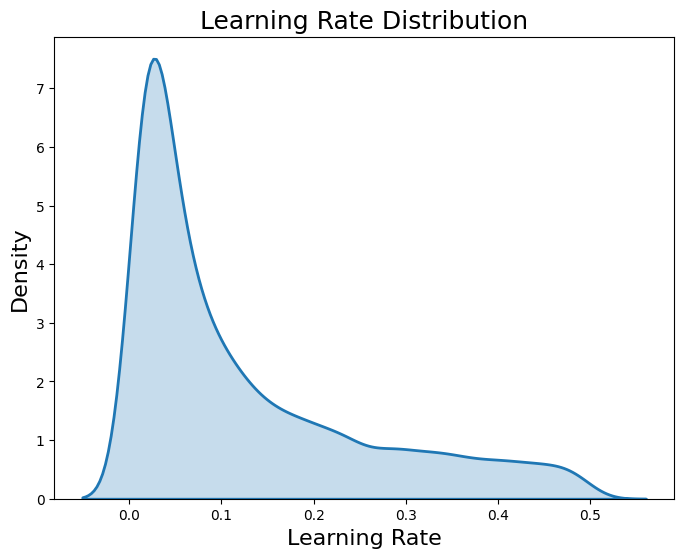

In [ ]:
learning_rate_dist = []
for _ in range(10000):
    learning_rate_dist.append(sample(space)['learning_rate'])

# kdeplot
plt.figure(figsize=(8, 6))
sns.kdeplot(learning_rate_dist, linewidth=2, shade=True)
plt.title('Learning Rate Distribution', size=18)
plt.xlabel('Learning Rate', size=16)
plt.ylabel('Density', size=16)
plt.show()

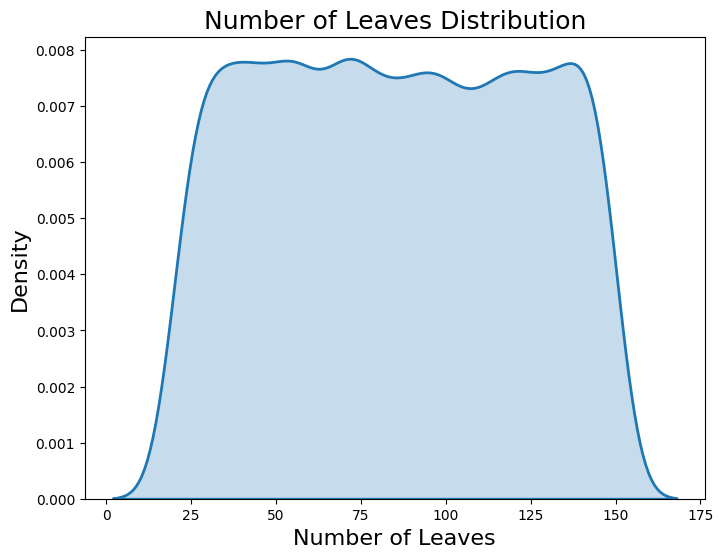

In [ ]:
num_leaves_dist = []
for _ in range(10000):
    num_leaves_dist.append(sample(space)['num_leaves'])


plt.figure(figsize=(8, 6))
sns.kdeplot(num_leaves_dist, linewidth=2, fill=True)
plt.title('Number of Leaves Distribution', size=18)
plt.xlabel('Number of Leaves', size=16)
plt.ylabel('Density', size=16)
plt.show()

In [ ]:
x = sample(space)

subsample = x['boosting_type'].get('subsample', 1.0)
x['boosting_type'] = x['boosting_type']['boosting_type']
x['subsample'] = subsample

x

{'boosting_type': 'gbdt',
 'colsample_bytree': 0.9395048879819975,
 'is_unbalance': False,
 'learning_rate': 0.3489518734020519,
 'min_child_samples': 110.0,
 'num_leaves': 83.0,
 'reg_alpha': 0.15513234188012837,
 'reg_lambda': 0.5896465371484237,
 'subsample_for_bin': 400.0,
 'subsample': 0.8617253910263212}

In [ ]:
from hyperopt import fmin
import csv
from hyperopt import STATUS_OK
from timeit import default_timer as timer

In [ ]:
def createDF(index=None):
  return pd.DataFrame(columns=['loss', 'hyperparameters', 'iteration', 'auc_score', 'l2_score', 'huber_score', 'runtime', 'time_after_iteration'],
                      index=index)

In [ ]:
bayesian_results_df = createDF()


In [ ]:
def objective(hyperparameters):
    global ITERATION, bayesian_results_df


    if 'n_estimators' in hyperparameters:
        del hyperparameters['n_estimators']

    boosting_type_info = hyperparameters['boosting_type']
    subsample = boosting_type_info.get('subsample', 1.0)
    hyperparameters['boosting_type'] = boosting_type_info['boosting_type']
    hyperparameters['subsample'] = subsample

    for parameter_name in ['num_leaves', 'min_child_samples']:
        hyperparameters[parameter_name] = int(hyperparameters[parameter_name])

    subsample_for_bin = int(hyperparameters.get('subsample_for_bin', 200))
    hyperparameters['subsample_for_bin'] = subsample_for_bin

    hyperparameters['verbosity'] = -1

    train_set = lgb.Dataset(data=train_features, label=train_labels, free_raw_data=False,
                            params={'subsample_for_bin': subsample_for_bin})

    start = timer()
    print(f"Starting LightGBM cross-validation for ITERATION {ITERATION} with parameters: {hyperparameters}")
    cv_results = lgb.cv(hyperparameters, train_set, num_boost_round=100, nfold=N_FOLDS,
                        metrics=['auc', 'l2', 'huber'], seed=50)
    run_time = timer() - start

    auc_score = cv_results['valid auc-mean'][-1]
    l2_score = cv_results['valid l2-mean'][-1]
    huber_score = cv_results['valid huber-mean'][-1]
    loss = 1 - auc_score
    n_estimators = len(cv_results['valid auc-mean'])
    hyperparameters['n_estimators'] = n_estimators

    new_row = {
        'loss': loss,
        'hyperparameters': hyperparameters,
        'iteration': ITERATION,
        'runtime': run_time,
        'auc_score': auc_score,
        'l2_score': l2_score,
        'huber_score': huber_score,
    }
    new_row_df = pd.DataFrame([new_row])
    bayesian_results_df = pd.concat([bayesian_results_df, new_row_df], ignore_index=True)

    print(f"Iteration {ITERATION}: n_estimators = {n_estimators}, Loss = {loss:.5f}, AUC = {auc_score:.5f}, Time = {run_time:.2f}s")
    ITERATION += 1

    return {'loss': loss, 'hyperparameters': hyperparameters, 'iteration': ITERATION,
            'train_time': run_time, 'status': STATUS_OK}

In [ ]:
from hyperopt import fmin, tpe, atpe, hp, Trials, STATUS_OK

tpe_algorithm = tpe.suggest
trials = Trials()
from hyperopt import fmin

In [ ]:
import warnings
np.warnings = warnings

In [ ]:
def flatten_hyperparameters(hyperparameters):
    flat_hyperparameters = {}
    for key, value in hyperparameters.items():
        if isinstance(value, list):
            flat_hyperparameters[key] = value[0] if value else None  # Handle empty lists
        elif isinstance(value, dict):
            for subkey, subvalue in value.items():
                flat_hyperparameters[f"{key}_{subkey}"] = subvalue
        else:
            flat_hyperparameters[key] = value
    return flat_hyperparameters

def run_optimization(algo, max_evals=20, label='TPE'):
    global ITERATION, bayesian_results_df
    ITERATION = 0
    bayesian_results_df = pd.DataFrame(columns=['loss', 'hyperparameters', 'iteration', 'runtime', 'auc_score', 'l2_score', 'huber_score'])
    trials = Trials()
    best = fmin(fn=objective, space=space, algo=algo, trials=trials, max_evals=max_evals)

    sampled_hyperparameters = []
    for trial in trials.trials:
        flat_hyperparameters = flatten_hyperparameters(trial['misc']['vals'])
        sampled_hyperparameters.append(flat_hyperparameters)

    sampled_hyperparameters_df = pd.DataFrame(sampled_hyperparameters)
    sampled_hyperparameters_df['method'] = label

    bayesian_results_df['time_after_iteration'] = bayesian_results_df['runtime'].cumsum()
    return bayesian_results_df, sampled_hyperparameters_df, trials

tpe_results, tpe_samples, tpe_trials = run_optimization(tpe.suggest, max_evals=MAX_EVALS, label='TPE')

atpe_results, atpe_samples, atpe_trials = run_optimization(atpe.suggest, max_evals=MAX_EVALS, label='ATPE')

combined_results = pd.concat([
    tpe_results.drop(columns=['hyperparameters']).assign(Method='TPE'),
    atpe_results.drop(columns=['hyperparameters']).assign(Method='ATPE')
], ignore_index=True)

combined_samples = pd.concat([
    tpe_samples,
    atpe_samples
], ignore_index=True)

summary_table = combined_results.groupby('Method').agg({
    'loss': ['mean', 'std', 'min'],
    'runtime': ['mean', 'std']
})

threshold_loss = combined_results['loss'].median()

combined_results['result_type'] = np.where(combined_results['loss'] > threshold_loss, 'bad', 'good')

combined_samples = combined_samples.reset_index(drop=True)
combined_results = combined_results.reset_index(drop=True)

combined_samples = pd.concat([combined_samples, combined_results[['Method', 'result_type']]], axis=1)

Starting LightGBM cross-validation for ITERATION 0 with parameters: {'boosting_type': 'dart', 'colsample_bytree': 0.7423107821112286, 'is_unbalance': False, 'learning_rate': 0.40795835862449864, 'min_child_samples': 335, 'num_leaves': 115, 'reg_alpha': 0.17534804175488095, 'reg_lambda': 0.17115247091444985, 'subsample_for_bin': 400, 'subsample': 0.7549362968871712, 'verbosity': -1}
Iteration 0: n_estimators = 100, Loss = 0.31621, AUC = 0.68379, Time = 1.66s
Starting LightGBM cross-validation for ITERATION 1 with parameters: {'boosting_type': 'dart', 'colsample_bytree': 0.8853854223259956, 'is_unbalance': True, 'learning_rate': 0.017554725420809245, 'min_child_samples': 240, 'num_leaves': 140, 'reg_alpha': 0.8173720174560364, 'reg_lambda': 0.6070772106258656, 'subsample_for_bin': 400, 'subsample': 0.9840416198410546, 'verbosity': -1}
Iteration 1: n_estimators = 100, Loss = 0.27986, AUC = 0.72014, Time = 1.86s
Starting LightGBM cross-validation for ITERATION 2 with parameters: {'boosting

KeyboardInterrupt: 

In [ ]:
tpe_results

,loss,hyperparameters,iteration,runtime,auc_score,l2_score,huber_score,time_after_iteration
0,0.296233,"{'boosting_type': 'dart', 'colsample_bytree': ...",0,11.715036,0.703767,0.071393,0.035626,11.715036
1,0.285893,"{'boosting_type': 'dart', 'colsample_bytree': ...",1,10.958921,0.714107,0.074093,0.036979,22.673956
2,0.277634,"{'boosting_type': 'dart', 'colsample_bytree': ...",2,19.756113,0.722366,0.070831,0.035361,42.430069
3,0.282213,"{'boosting_type': 'dart', 'colsample_bytree': ...",3,2.664461,0.717787,0.071369,0.035622,45.094530
4,0.277468,"{'boosting_type': 'goss', 'colsample_bytree': ...",4,0.792308,0.722532,0.070587,0.035248,45.886838
5,0.275512,"{'boosting_type': 'goss', 'colsample_bytree': ...",5,0.799587,0.724488,0.070708,0.035320,46.686426
6,0.285274,"{'boosting_type': 'dart', 'colsample_bytree': ...",6,1.478673,0.714726,0.073269,0.036572,48.165099
7,0.275899,"{'boosting_type': 'gbdt', 'colsample_bytree': ...",7,0.993617,0.724101,0.070561,0.035234,49.158715
8,0.285879,"{'boosting_type': 'dart', 'colsample_bytree': ...",8,5.851266,0.714121,0.070582,0.035230,55.009981
9,0.274805,"{'boosting_type': 'goss', 'colsample_bytree': ...",9,0.808097,0.725195,0.070448,0.035175,55.818079


# Results

In [ ]:
summary_table

loss                       runtime          
            mean       std       min      mean       std
Method                                                  
ATPE    0.280558  0.013767  0.269741  2.036258  1.372669
TPE     0.284929  0.016610  0.269969  3.290866  4.140045

In [ ]:
combined_samples

,boosting_type,colsample_by_tree,dart_subsample,gdbt_subsample,is_unbalance,learning_rate,min_child_samples,num_leaves,reg_alpha,reg_lambda,subsample_for_bin,method,Method,result_type
0,1,0.707326,0.997510,NaN,1,0.189796,145.0,86.0,0.799367,0.445909,400.0,TPE,TPE,bad
1,1,0.655622,0.737143,NaN,0,0.011036,485.0,89.0,0.467744,0.316190,400.0,TPE,TPE,bad
2,1,0.931231,0.560058,NaN,1,0.058405,300.0,93.0,0.926294,0.076936,400.0,TPE,TPE,bad
3,1,0.947058,0.557293,NaN,1,0.034788,135.0,67.0,0.257167,0.811614,400.0,TPE,TPE,bad
4,2,0.933961,NaN,NaN,1,0.099535,380.0,134.0,0.267639,0.262982,400.0,TPE,TPE,bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2,0.775423,0.759803,0.573329,0,0.023962,125.0,96.0,0.652596,0.593340,400.0,ATPE,ATPE,good
96,2,0.778278,0.770504,0.565054,0,0.023659,215.0,94.0,0.731345,0.555995,400.0,ATPE,ATPE,good
97,2,0.781696,0.776529,0.563692,0,0.025271,255.0,86.0,0.840164,0.571390,400.0,ATPE,ATPE,good
98,2,0.771805,0.780465,0.559251,0,0.037446,270.0,78.0,0.871330,0.528289,400.0,ATPE,ATPE,good


## Acquisition function plots

Starting LightGBM cross-validation for ITERATION 50 with parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'num_leaves': 20, 'subsample_for_bin': 200, 'min_child_samples': 20, 'reg_alpha': 0, 'reg_lambda': 0, 'colsample_bytree': 0.6, 'is_unbalance': False, 'subsample': 1.0, 'verbosity': -1}
Iteration 50: n_estimators = 100, Loss = 0.30755, AUC = 0.69245, Time = 4.49s
Starting LightGBM cross-validation for ITERATION 51 with parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'num_leaves': 34, 'subsample_for_bin': 200, 'min_child_samples': 20, 'reg_alpha': 0, 'reg_lambda': 0, 'colsample_bytree': 0.6, 'is_unbalance': False, 'subsample': 1.0, 'verbosity': -1}
Iteration 51: n_estimators = 100, Loss = 0.32259, AUC = 0.67741, Time = 9.61s
Starting LightGBM cross-validation for ITERATION 52 with parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'num_leaves': 48, 'subsample_for_bin': 200, 'min_child_samples': 20, 'reg_alpha': 0, 'reg_lambda': 0, 'colsample_bytree': 0

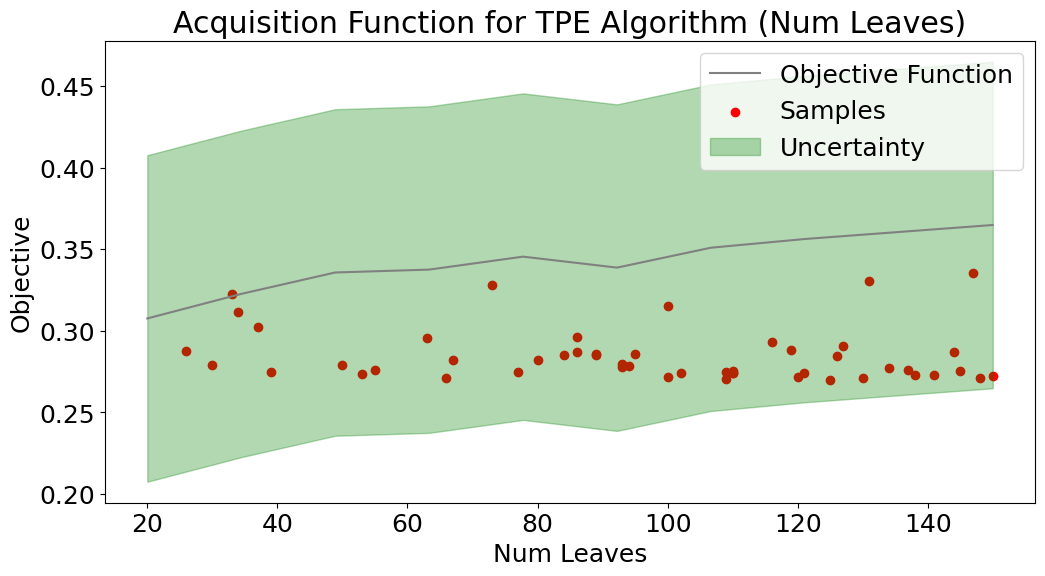

In [ ]:
num_leaves = np.linspace(20, 150, 10)
ys_nl = np.array([objective({'boosting_type': {'boosting_type': 'gbdt'}, 'learning_rate': 0.1, 'num_leaves': int(nl), 'subsample_for_bin': 200, 'min_child_samples': 20, 'reg_alpha': 0, 'reg_lambda': 0, 'colsample_bytree': 0.6, 'is_unbalance': False})['loss'] for nl in num_leaves])

surrogate_means_nl = np.array([trial['result']['loss'] for trial in tpe_trials.trials])
surrogate_means_nl_vals = np.array([trial['misc']['vals']['num_leaves'][0] for trial in tpe_trials.trials])

plt.figure(figsize=(12, 6))
plt.plot(num_leaves, ys_nl, label='Objective Function', color='gray')
plt.scatter(surrogate_means_nl_vals, surrogate_means_nl, color='red', label='Samples')
plt.fill_between(num_leaves, ys_nl - 0.1, ys_nl + 0.1, alpha=0.3, color='green', label='Uncertainty')
plt.title('Acquisition Function for TPE Algorithm (Num Leaves)')
plt.xlabel('Num Leaves')
plt.ylabel('Objective')
plt.legend()
plt.show()

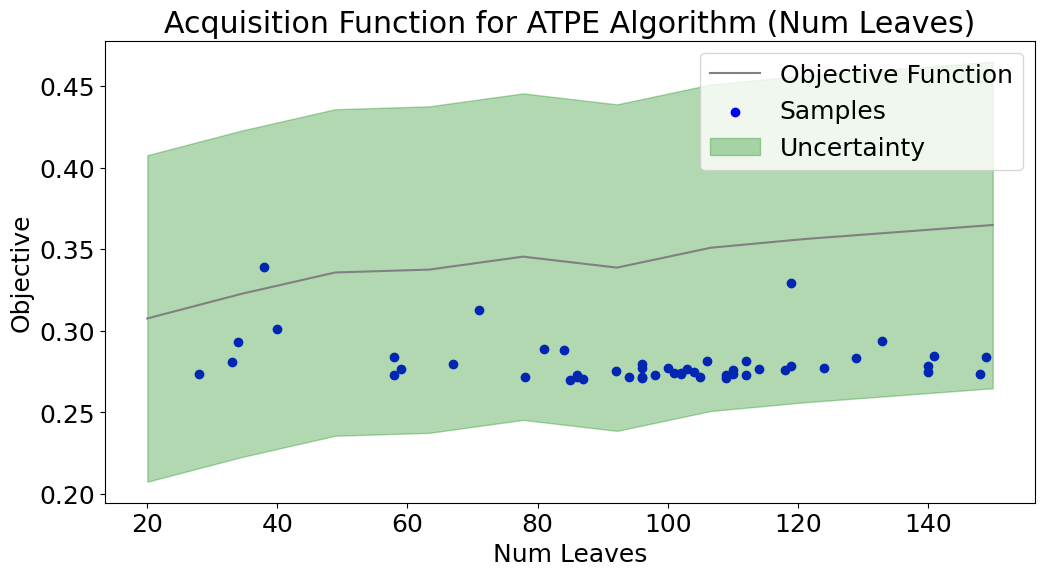

In [ ]:
atpe_surrogate_means_nl = np.array([trial['result']['loss'] for trial in atpe_trials.trials])
atpe_surrogate_means_nl_vals = np.array([trial['misc']['vals']['num_leaves'][0] for trial in atpe_trials.trials])

plt.figure(figsize=(12, 6))
plt.plot(num_leaves, ys_nl, label='Objective Function', color='gray')
plt.scatter(atpe_surrogate_means_nl_vals, atpe_surrogate_means_nl, color='blue', label='Samples')
plt.fill_between(num_leaves, ys_nl - 0.1, ys_nl + 0.1, alpha=0.3, color='green', label='Uncertainty')
plt.title('Acquisition Function for ATPE Algorithm (Num Leaves)')
plt.xlabel('Num Leaves')
plt.ylabel('Objective')
plt.legend()
plt.show()


Starting LightGBM cross-validation for ITERATION 60 with parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'num_leaves': 31, 'subsample_for_bin': 200, 'min_child_samples': 20, 'reg_alpha': 0, 'reg_lambda': 0, 'colsample_bytree': 0.6, 'is_unbalance': False, 'subsample': 1.0, 'verbosity': -1}
Iteration 60: n_estimators = 100, Loss = 0.27856, AUC = 0.72144, Time = 1.32s
Starting LightGBM cross-validation for ITERATION 61 with parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.01544452104946379, 'num_leaves': 31, 'subsample_for_bin': 200, 'min_child_samples': 20, 'reg_alpha': 0, 'reg_lambda': 0, 'colsample_bytree': 0.6, 'is_unbalance': False, 'subsample': 1.0, 'verbosity': -1}
Iteration 61: n_estimators = 100, Loss = 0.28102, AUC = 0.71898, Time = 1.32s
Starting LightGBM cross-validation for ITERATION 62 with parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.023853323044733008, 'num_leaves': 31, 'subsample_for_bin': 200, 'min_child_samples': 20, 'reg_alpha': 0, 'reg

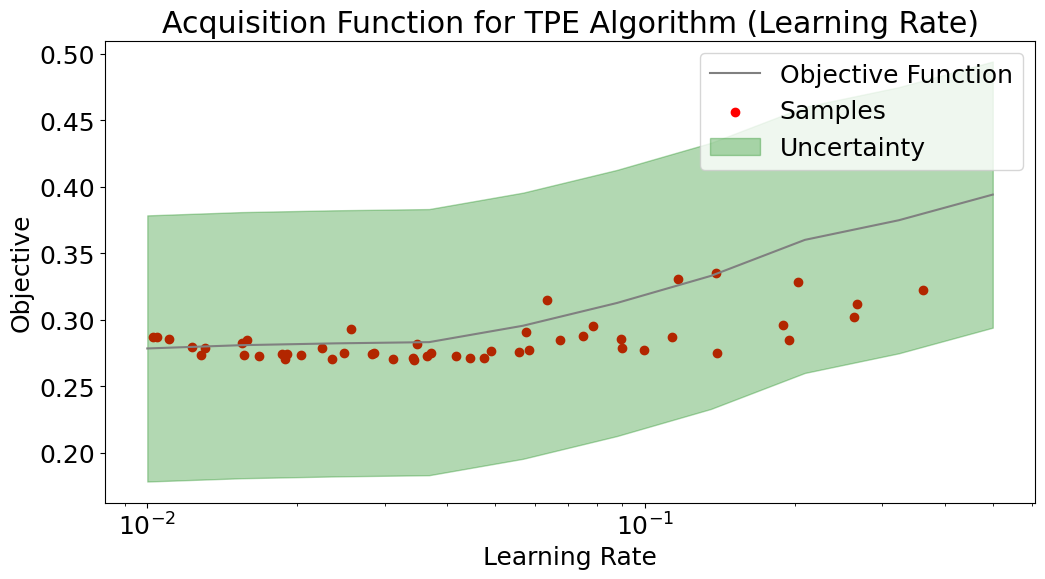

In [ ]:
learning_rates = np.logspace(np.log10(0.01), np.log10(0.5), 10)
ys_lr = np.array([objective({'boosting_type': {'boosting_type': 'gbdt'}, 'learning_rate': lr, 'num_leaves': 31, 'subsample_for_bin': 200, 'min_child_samples': 20, 'reg_alpha': 0, 'reg_lambda': 0, 'colsample_bytree': 0.6, 'is_unbalance': False})['loss'] for lr in learning_rates])

surrogate_means_lr = np.array([trial['result']['loss'] for trial in tpe_trials.trials])
surrogate_means_lr_vals = np.array([trial['misc']['vals']['learning_rate'][0] for trial in tpe_trials.trials])

plt.figure(figsize=(12, 6))
plt.plot(learning_rates, ys_lr, label='Objective Function', color='gray')
plt.scatter(surrogate_means_lr_vals, surrogate_means_lr, color='red', label='Samples')
plt.fill_between(learning_rates, ys_lr - 0.1, ys_lr + 0.1, alpha=0.3, color='green', label='Uncertainty')
plt.title('Acquisition Function for TPE Algorithm (Learning Rate)')
plt.xlabel('Learning Rate')
plt.ylabel('Objective')
plt.xscale('log')
plt.legend()
plt.show()


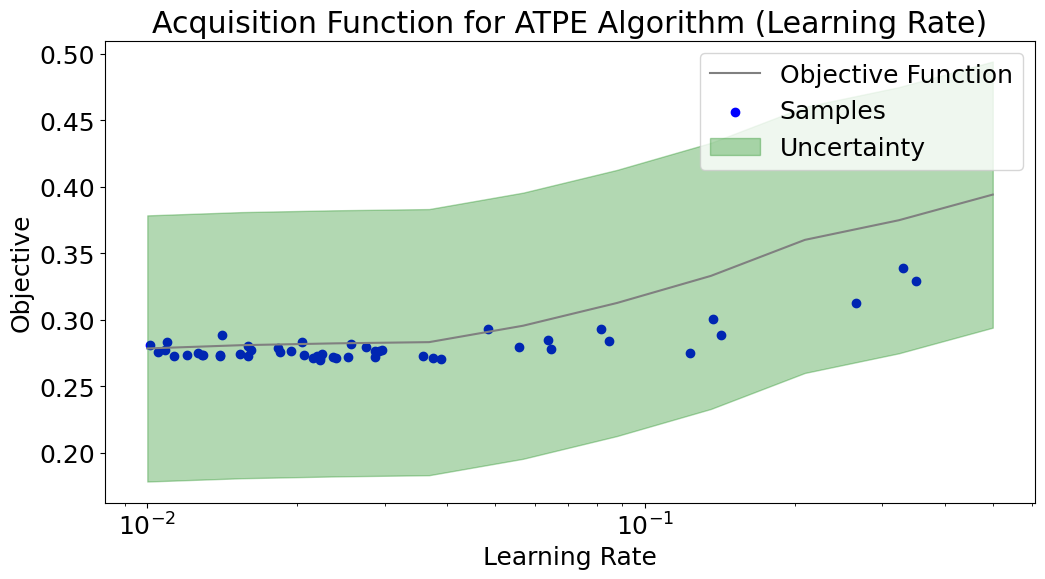

In [ ]:
atpe_surrogate_means_lr = np.array([trial['result']['loss'] for trial in atpe_trials.trials])
atpe_surrogate_means_lr_vals = np.array([trial['misc']['vals']['learning_rate'][0] for trial in atpe_trials.trials])

plt.figure(figsize=(12, 6))
plt.plot(learning_rates, ys_lr, label='Objective Function', color='gray')
plt.scatter(atpe_surrogate_means_lr_vals, atpe_surrogate_means_lr, color='blue', label='Samples')
plt.fill_between(learning_rates, ys_lr - 0.1, ys_lr + 0.1, alpha=0.3, color='green', label='Uncertainty')
plt.title('Acquisition Function for ATPE Algorithm (Learning Rate)')
plt.xlabel('Learning Rate')
plt.ylabel('Objective')
plt.xscale('log')
plt.legend()
plt.show()

## Baeysian Hyperparameters

In [ ]:
tpe_results

,loss,hyperparameters,iteration,runtime,auc_score,l2_score,huber_score,time_after_iteration
0,0.296233,"{'boosting_type': 'dart', 'colsample_bytree': ...",0,11.715036,0.703767,0.071393,0.035626,11.715036
1,0.285893,"{'boosting_type': 'dart', 'colsample_bytree': ...",1,10.958921,0.714107,0.074093,0.036979,22.673956
2,0.277634,"{'boosting_type': 'dart', 'colsample_bytree': ...",2,19.756113,0.722366,0.070831,0.035361,42.430069
3,0.282213,"{'boosting_type': 'dart', 'colsample_bytree': ...",3,2.664461,0.717787,0.071369,0.035622,45.094530
4,0.277468,"{'boosting_type': 'goss', 'colsample_bytree': ...",4,0.792308,0.722532,0.070587,0.035248,45.886838
5,0.275512,"{'boosting_type': 'goss', 'colsample_bytree': ...",5,0.799587,0.724488,0.070708,0.035320,46.686426
6,0.285274,"{'boosting_type': 'dart', 'colsample_bytree': ...",6,1.478673,0.714726,0.073269,0.036572,48.165099
7,0.275899,"{'boosting_type': 'gbdt', 'colsample_bytree': ...",7,0.993617,0.724101,0.070561,0.035234,49.158715
8,0.285879,"{'boosting_type': 'dart', 'colsample_bytree': ...",8,5.851266,0.714121,0.070582,0.035230,55.009981
9,0.274805,"{'boosting_type': 'goss', 'colsample_bytree': ...",9,0.808097,0.725195,0.070448,0.035175,55.818079


In [ ]:
atpe_results

,loss,hyperparameters,iteration,runtime,auc_score,l2_score,huber_score,time_after_iteration
0,0.283729,"{'boosting_type': 'dart', 'colsample_bytree': ...",0,4.832383,0.716271,0.072888,0.036386,4.832383
1,0.338949,"{'boosting_type': 'gbdt', 'colsample_bytree': ...",1,1.218760,0.661051,0.076268,0.037982,6.051143
2,0.279654,"{'boosting_type': 'dart', 'colsample_bytree': ...",2,1.584328,0.720346,0.072133,0.036010,7.635471
3,0.279930,"{'boosting_type': 'dart', 'colsample_bytree': ...",3,1.771314,0.720070,0.070993,0.035442,9.406785
4,0.284692,"{'boosting_type': 'gbdt', 'colsample_bytree': ...",4,1.312119,0.715308,0.070789,0.035338,10.718905
5,0.288493,"{'boosting_type': 'dart', 'colsample_bytree': ...",5,1.637764,0.711507,0.073337,0.036603,12.356669
6,0.300812,"{'boosting_type': 'gbdt', 'colsample_bytree': ...",6,1.102301,0.699188,0.071945,0.035893,13.458970
7,0.293553,"{'boosting_type': 'gbdt', 'colsample_bytree': ...",7,4.333044,0.706447,0.070868,0.035371,17.792014
8,0.292847,"{'boosting_type': 'goss', 'colsample_bytree': ...",8,1.723781,0.707153,0.071632,0.035754,19.515795
9,0.283806,"{'boosting_type': 'gbdt', 'colsample_bytree': ...",9,1.060412,0.716194,0.070882,0.035385,20.576207


In [ ]:
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
import ast

def evaluate(results, name):
    """Evaluate model on test data using hyperparameters in results
       Return dataframe of hyperparameters"""

    new_results = results.copy()

    if isinstance(new_results['hyperparameters'].iloc[0], str):
        new_results['hyperparameters'] = new_results['hyperparameters'].apply(ast.literal_eval)

    def convert_hyperparams(hyperparams):
        for key in ['num_leaves', 'min_child_samples', 'subsample_for_bin', 'n_estimators']:
            if key in hyperparams:
                hyperparams[key] = int(hyperparams[key])
        return hyperparams

    new_results['hyperparameters'] = new_results['hyperparameters'].apply(convert_hyperparams)

    max_ind = new_results['auc_score'].idxmax()

    print('The highest cross-validation score from {} was {:.5f} found on iteration {}.'.format(name, new_results.loc[max_ind, 'auc_score'], new_results.loc[max_ind, 'iteration']))

    new_results = new_results.sort_values('auc_score', ascending=False).reset_index(drop=True)

    hyperparameters = new_results.loc[0, 'hyperparameters']
    model = lgb.LGBMClassifier(**hyperparameters)

    model.fit(train_features, train_labels)
    preds = model.predict_proba(test_features)[:, 1]

    print('ROC AUC from {} on test data = {:.5f}.'.format(name, roc_auc_score(test_labels, preds)))

    hyp_df = pd.DataFrame(columns=list(hyperparameters.keys()))

    for hyp in new_results['hyperparameters']:
        hyp = convert_hyperparams(hyp)

        current_hyp_df = pd.DataFrame([hyp])
        hyp_df = pd.concat([hyp_df, current_hyp_df], ignore_index=True)

    hyp_df['iteration'] = new_results['iteration']
    hyp_df['auc_score'] = new_results['auc_score']
    hyp_df['l2_score'] = new_results['l2_score']
    hyp_df['huber_score'] = new_results['huber_score']
    hyp_df['runtime'] = new_results['runtime']
    hyp_df['time_after_iteration'] = new_results['time_after_iteration']
    hyp_df['total_runtime'] = new_results['time_after_iteration'].max()

    return hyp_df

In [ ]:
bayes_hyp_tpe = evaluate(tpe_results, name = 'Bayesian')
bayes_hyp_tpe

The highest cross-validation score from Bayesian was 0.73003 found on iteration 34.
ROC AUC from Bayesian on test data = 0.73671.


,boosting_type,colsample_bytree,is_unbalance,learning_rate,min_child_samples,num_leaves,reg_alpha,reg_lambda,subsample_for_bin,subsample,verbosity,n_estimators,iteration,auc_score,l2_score,huber_score,runtime,time_after_iteration,total_runtime
0,goss,0.834685,False,0.034345,165,125,0.206714,0.840416,400,1.000000,-1,100,34,0.730031,0.070152,0.035040,1.179729,103.386427,164.543275
1,goss,0.775329,True,0.018908,225,109,0.599166,0.988984,400,1.000000,-1,100,23,0.729234,0.070511,0.035228,1.127955,86.487057,164.543275
2,goss,0.795413,False,0.031157,135,66,0.295053,0.530052,400,1.000000,-1,100,44,0.729205,0.070202,0.035066,2.139200,126.286034,164.543275
3,goss,0.750697,False,0.023541,165,130,0.218927,0.749460,400,1.000000,-1,100,35,0.729108,0.070344,0.035141,1.229270,104.615697,164.543275
4,goss,0.825627,False,0.034222,275,148,0.409191,0.639741,400,1.000000,-1,100,36,0.728663,0.070282,0.035107,0.969166,105.584863,164.543275
5,goss,0.890978,True,0.044528,205,120,0.109500,0.884710,400,1.000000,-1,100,26,0.728449,0.070145,0.035033,1.046519,89.803216,164.543275
6,goss,0.893510,True,0.047393,215,100,0.150654,0.877965,400,1.000000,-1,100,27,0.728320,0.070243,0.035081,1.012485,90.815702,164.543275
7,goss,0.718208,False,0.016736,190,150,0.766137,0.946136,400,1.000000,-1,100,48,0.727440,0.070690,0.035320,10.724134,156.090117,164.543275
8,goss,0.746261,True,0.041704,285,141,0.062723,0.886267,400,1.000000,-1,100,29,0.727329,0.070283,0.035104,4.433598,96.546611,164.543275
9,goss,0.633487,False,0.036415,175,138,0.992442,0.844839,400,1.000000,-1,100,41,0.726889,0.070225,0.035077,1.060328,116.516044,164.543275


In [ ]:
bayes_hyp_atpe = evaluate(atpe_results, name = 'Bayesian')
bayes_hyp_atpe

The highest cross-validation score from Bayesian was 0.73026 found on iteration 44.
ROC AUC from Bayesian on test data = 0.74125.


,boosting_type,colsample_bytree,is_unbalance,learning_rate,min_child_samples,num_leaves,reg_alpha,reg_lambda,subsample_for_bin,subsample,verbosity,n_estimators,iteration,auc_score,l2_score,huber_score,runtime,time_after_iteration,total_runtime
0,goss,0.751595,True,0.022219,225,85,0.838541,0.517983,400,1.000000,-1,100,44,0.730259,0.070374,0.035158,1.096780,92.973181,101.812888
1,goss,0.753898,True,0.038933,265,87,0.872828,0.574484,400,1.000000,-1,100,43,0.729632,0.070239,0.035084,0.964529,91.876401,101.812888
2,goss,0.775423,True,0.023962,125,96,0.652596,0.593340,400,1.000000,-1,100,45,0.728767,0.070298,0.035118,1.371070,94.344251,101.812888
3,goss,0.716782,True,0.021577,205,109,0.700418,0.304227,400,1.000000,-1,100,34,0.728681,0.070476,0.035209,1.153386,73.764889,101.812888
4,goss,0.771805,True,0.037446,270,78,0.871330,0.528289,400,1.000000,-1,100,48,0.728396,0.070307,0.035118,0.956330,100.754788,101.812888
5,goss,0.739182,True,0.022218,210,105,0.727179,0.334274,400,1.000000,-1,100,41,0.728319,0.070420,0.035181,2.124862,89.615563,101.812888
6,goss,0.781696,True,0.025271,255,86,0.840164,0.571390,400,1.000000,-1,100,47,0.728142,0.070445,0.035192,2.160899,99.798458,101.812888
7,goss,0.740550,True,0.028684,125,96,0.652596,0.113030,400,1.000000,-1,100,33,0.728125,0.070219,0.035076,1.316569,72.611503,101.812888
8,goss,0.778278,True,0.023659,215,94,0.731345,0.555995,400,1.000000,-1,100,46,0.728067,0.070393,0.035166,3.293308,97.637559,101.812888
9,goss,0.607909,True,0.015909,180,109,0.761550,0.343495,400,1.000000,-1,100,19,0.727391,0.070830,0.035392,1.185744,38.221553,101.812888


In [ ]:
import csv

## Manual Search

In [ ]:
small_param_grid = {
    'boosting_type': ['gbdt'],
    'num_leaves': [20, 100],
    'learning_rate': [0.005, 0.05],
    'subsample_for_bin': [20000, 200000],
    'min_child_samples': [20, 300],
    'reg_alpha': [0.0, 1.0],
    'reg_lambda': [0.0, 1.0],
    'colsample_bytree': [0.6, 1.0],
    'subsample': [0.5, 1.0],
    'is_unbalance': [True, False]
}

grid_size = (
    len(small_param_grid['boosting_type']) *
    len(small_param_grid['num_leaves']) *
    len(small_param_grid['learning_rate']) *
    len(small_param_grid['subsample_for_bin']) *
    len(small_param_grid['min_child_samples']) *
    len(small_param_grid['reg_alpha']) *
    len(small_param_grid['reg_lambda']) *
    len(small_param_grid['colsample_bytree']) *
    len(small_param_grid['subsample']) *
    len(small_param_grid['is_unbalance'])
)

grid_size, small_param_grid

(512,
 {'boosting_type': ['gbdt'],
  'num_leaves': [20, 100],
  'learning_rate': [0.005, 0.05],
  'subsample_for_bin': [20000, 200000],
  'min_child_samples': [20, 300],
  'reg_alpha': [0.0, 1.0],
  'reg_lambda': [0.0, 1.0],
  'colsample_bytree': [0.6, 1.0],
  'subsample': [0.5, 1.0],
  'is_unbalance': [True, False]})

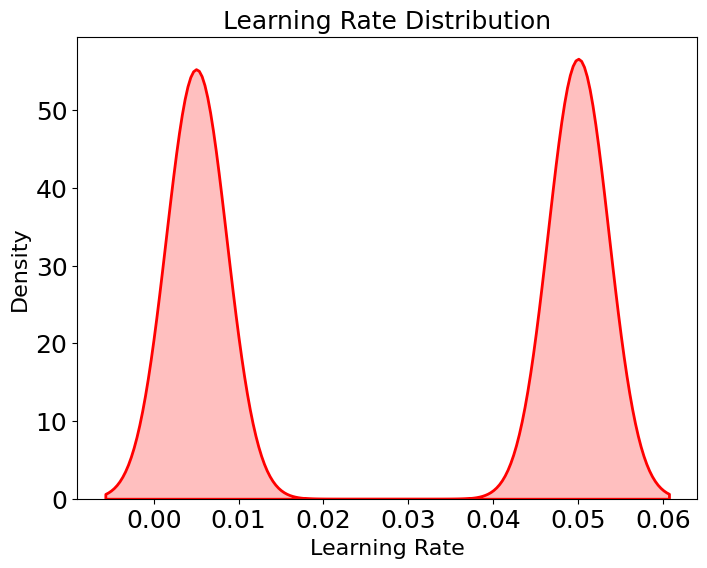

In [ ]:
import random

learning_rate_dist = []

for _ in range(10000):
    learning_rate_dist.append(random.choice(param_grid['learning_rate']))

plt.figure(figsize = (8, 6))
sns.kdeplot(learning_rate_dist, color = 'red', linewidth = 2, shade = True)
plt.title('Learning Rate Distribution', size = 18)
plt.xlabel('Learning Rate', size = 16)
plt.ylabel('Density', size = 16)
plt.show()

In [ ]:
import random

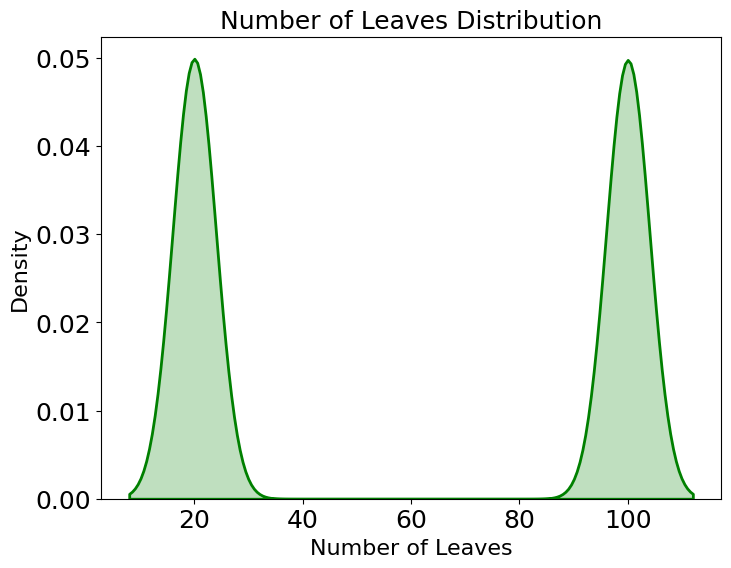

In [ ]:
num_leaves_dist = []

# Draw 10000 samples from the num_leaves domain
for _ in range(100000):
    num_leaves_dist.append(random.choice(param_grid['num_leaves']))

plt.figure(figsize = (8, 6))
sns.kdeplot(num_leaves_dist, color = 'green', linewidth = 2, shade = True)
plt.title('Number of Leaves Distribution', size = 18)
plt.xlabel('Number of Leaves', size = 16)
plt.ylabel('Density', size = 16)
plt.show()

In [ ]:
# Dataframes for random and grid search
random_results = createDF(index=list(range(MAX_EVALS)))

grid_results = createDF(index=list(range(MAX_EVALS)))

In [ ]:
import itertools
import pandas as pd

def grid_search(param_grid, max_evals):
    """Grid search algorithm (with limit on max evals)
       Stores result of search in a DataFrame."""

    results = pd.DataFrame(columns=['l2_score', 'huber_score', 'auc_score', 'params', 'iteration'])

    # https://codereview.stackexchange.com/questions/171173/list-all-possible-permutations-from-a-python-dictionary-of-lists
    keys, values = zip(*param_grid.items())

    i = 0

    for v in itertools.product(*values):
      start = timer()

      parameters = dict(zip(keys, v))

      if parameters['boosting_type'] == 'goss':
          parameters['subsample'] = 1.0

      eval_results = objective_manual(parameters, i)

      run_time = timer() - start

      new_row = pd.DataFrame([{
          'l2_score': eval_results[0],
          'huber_score': eval_results[1],
          'auc_score': eval_results[2],
          'hyperparameters': parameters,
          'iteration': i,
          'runtime': run_time
      }])

      results = pd.concat([results, new_row], ignore_index=True)

      i += 1

      if i >= max_evals:
          break

    results['time_after_iteration'] = results['runtime'].cumsum()

    results.sort_values('auc_score', ascending=False, inplace=True)
    results.reset_index(drop=True, inplace=True)

    return results

In [ ]:
N_FOLDS = 5

In [ ]:

def objective_manual(hyperparameters, iteration):
    """Objective function for grid and random search. Returns
       the cross validation score from a set of hyperparameters."""

    if 'n_estimators' in hyperparameters:
        del hyperparameters['n_estimators']

    # Adjust hyperparameters that need to be integers
    hyperparameters['num_leaves'] = int(hyperparameters.get('num_leaves', 31))
    hyperparameters['min_child_samples'] = int(hyperparameters.get('min_child_samples', 20))
    subsample_for_bin = int(hyperparameters.get('subsample_for_bin', 200))
    hyperparameters['subsample_for_bin'] = subsample_for_bin

    # Recreate the dataset with the current hyperparameters
    train_set = lgb.Dataset(data=train_features, label=train_labels, free_raw_data=False,
                            params={'subsample_for_bin': subsample_for_bin})

    cv_results = lgb.cv(hyperparameters, train_set, num_boost_round=3, nfold=N_FOLDS, metrics=['auc', 'l2', 'huber'], seed=42)

    auc_score = cv_results['valid auc-mean'][-1]
    l2_score = cv_results['valid l2-mean'][-1]
    huber_score = cv_results['valid huber-mean'][-1]
    estimators = len(cv_results['valid auc-mean'])
    hyperparameters['n_estimators'] = estimators

    return [huber_score, l2_score, auc_score, hyperparameters, iteration]

In [ ]:
param_grid = {
    'boosting_type': ['gbdt', 'goss', 'dart'],
    'num_leaves': list(range(20, 150)),
    'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.5), base = 10, num = 1000)),
    'subsample_for_bin': list(range(20000, 300000, 20000)),
    'min_child_samples': list(range(20, 500, 5)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.6, 1, 10)),
    'subsample': list(np.linspace(0.5, 1, 100)),
    'is_unbalance': [True, False]
}

In [ ]:
def random_search(param_grid, max_evals):
    """Random search for hyperparameter optimization.
       Stores result of search in a DataFrame."""

    results = pd.DataFrame(columns=['l2_score', 'huber_score', 'auc_score', 'params', 'iteration'])

    for i in range(max_evals):
        start = timer()
        random_params = {k: random.sample(v, 1)[0] for k, v in param_grid.items()}
        random_params['subsample'] = 1.0 if random_params['boosting_type'] == 'goss' else random_params['subsample']

        eval_results = objective_manual(random_params, i)

        new_row = pd.DataFrame([{
            'l2_score': eval_results[0],
            'huber_score': eval_results[1],
            'auc_score': eval_results[2],
            'hyperparameters': random_params,
            'iteration': i,
            'runtime': (timer() - start)
        }])

        results = pd.concat([results, new_row], ignore_index=True)

    results['time_after_iteration'] = results['runtime'].cumsum()

    results.sort_values('auc_score', ascending=False, inplace=True)
    results.reset_index(drop=True, inplace=True)

    return results

In [ ]:
import csv


In [ ]:
grid_results = grid_search(small_param_grid, MAX_EVALS)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9993
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 93
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003197 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9993
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 93
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008868 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9993
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 93
[LightGB

In [ ]:
grid_results

,l2_score,huber_score,auc_score,params,iteration,hyperparameters,runtime,time_after_iteration
0,0.037463,0.074952,0.679953,NaN,0,"{'boosting_type': 'gbdt', 'num_leaves': 20, 'l...",0.500393,0.500393
1,0.037463,0.074952,0.679953,NaN,1,"{'boosting_type': 'gbdt', 'num_leaves': 20, 'l...",1.098327,1.598720
2,0.037463,0.074952,0.679953,NaN,2,"{'boosting_type': 'gbdt', 'num_leaves': 20, 'l...",0.879565,2.478285
3,0.037463,0.074952,0.679953,NaN,3,"{'boosting_type': 'gbdt', 'num_leaves': 20, 'l...",1.275351,3.753636
4,0.037463,0.074952,0.679953,NaN,4,"{'boosting_type': 'gbdt', 'num_leaves': 20, 'l...",1.074498,4.828133
5,0.037463,0.074952,0.679953,NaN,5,"{'boosting_type': 'gbdt', 'num_leaves': 20, 'l...",0.481142,5.309275
6,0.037463,0.074952,0.679953,NaN,6,"{'boosting_type': 'gbdt', 'num_leaves': 20, 'l...",0.367258,5.676533
7,0.037463,0.074952,0.679953,NaN,7,"{'boosting_type': 'gbdt', 'num_leaves': 20, 'l...",0.333753,6.010286
8,0.037463,0.074952,0.679953,NaN,8,"{'boosting_type': 'gbdt', 'num_leaves': 20, 'l...",0.331428,6.341715
9,0.037463,0.074952,0.679953,NaN,9,"{'boosting_type': 'gbdt', 'num_leaves': 20, 'l...",0.354392,6.696107


In [ ]:
random_results = random_search(param_grid,MAX_EVALS)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007638 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9975
[LightGBM] [Info] Number of data points in the train set: 6666, number of used features: 84
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9975
[LightGBM] [Info] Number of data points in the train set: 6667, number of used features: 84
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002866 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9975
[LightGBM] [Info] Number of data points in the train set: 6667, number of used features: 84
[LightGB

In [ ]:
random_results

,l2_score,huber_score,auc_score,params,iteration,hyperparameters,runtime,time_after_iteration
0,0.036095,0.072225,0.707616,NaN,6,"{'boosting_type': 'goss', 'num_leaves': 37, 'l...",0.395219,5.634690
1,0.037316,0.074655,0.700621,NaN,0,"{'boosting_type': 'dart', 'num_leaves': 104, '...",0.382632,0.382632
2,0.035671,0.071433,0.696130,NaN,4,"{'boosting_type': 'dart', 'num_leaves': 106, '...",0.431315,4.894842
3,0.037226,0.074472,0.693207,NaN,2,"{'boosting_type': 'dart', 'num_leaves': 143, '...",1.290005,2.519575
4,0.036765,0.073554,0.693082,NaN,3,"{'boosting_type': 'dart', 'num_leaves': 44, 'l...",1.943953,4.463528
5,0.037437,0.074899,0.690741,NaN,8,"{'boosting_type': 'goss', 'num_leaves': 72, 'l...",0.382761,6.546111
6,0.037072,0.074165,0.686769,NaN,5,"{'boosting_type': 'dart', 'num_leaves': 67, 'l...",0.344629,5.239472
7,0.036272,0.072585,0.683113,NaN,9,"{'boosting_type': 'dart', 'num_leaves': 47, 'l...",0.450886,6.996997
8,0.037243,0.074508,0.680881,NaN,7,"{'boosting_type': 'dart', 'num_leaves': 144, '...",0.528661,6.163351
9,0.036459,0.072961,0.660801,NaN,1,"{'boosting_type': 'gbdt', 'num_leaves': 63, 'l...",0.846937,1.229570


## Hyperband

In [ ]:
!pip install numpy lightgbm
!pip install keras-tuner
!pip install scikit-learn

In [ ]:
import keras_tuner as kt
import lightgbm as lgb
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from timeit import default_timer as timer

ITERATION = 0
hyperband_results_df = createDF()

N_FOLDS = 5

def hyp_objective(hyperparameters):
    global ITERATION, hyperband_results_df

    if 'n_estimators' in hyperparameters:
        del hyperparameters['n_estimators']

    boosting_type_info = hyperparameters['boosting_type']
    subsample = boosting_type_info.get('subsample', 1.0)
    hyperparameters['boosting_type'] = boosting_type_info['boosting_type']
    hyperparameters['subsample'] = subsample

    for parameter_name in ['num_leaves', 'min_child_samples']:
        hyperparameters[parameter_name] = int(hyperparameters[parameter_name])

    subsample_for_bin = int(hyperparameters.get('subsample_for_bin', 200))
    hyperparameters['subsample_for_bin'] = subsample_for_bin

    hyperparameters['verbosity'] = -1

    train_set = lgb.Dataset(data=train_features, label=train_labels, free_raw_data=False,
                            params={'subsample_for_bin': subsample_for_bin})

    start = timer()
    print(f"Starting LightGBM cross-validation for ITERATION {ITERATION} with parameters: {hyperparameters}")
    cv_results = lgb.cv(hyperparameters, train_set, num_boost_round=100, nfold=N_FOLDS,
                        metrics=['auc', 'l2', 'huber'], seed=50)
    run_time = timer() - start

    auc_score = cv_results['valid auc-mean'][-1]
    l2_score = cv_results['valid l2-mean'][-1]
    huber_score = cv_results['valid huber-mean'][-1]
    loss = 1 - auc_score
    n_estimators = len(cv_results['valid auc-mean'])
    hyperparameters['n_estimators'] = n_estimators

    new_row = {
        'loss': loss,
        'hyperparameters': hyperparameters,
        'iteration': ITERATION,
        'runtime': run_time,
        'auc_score': auc_score,
        'l2_score': l2_score,
        'huber_score': huber_score,
    }
    new_row_df = pd.DataFrame([new_row])
    hyperband_results_df = pd.concat([hyperband_results_df, new_row_df], ignore_index=True)

    print(f"Iteration {ITERATION}: n_estimators = {n_estimators}, Loss = {loss:.5f}, AUC = {auc_score:.5f}, Time = {run_time:.2f}s")

    ITERATION += 1

    return {'loss': loss, 'hyperparameters': hyperparameters, 'iteration': ITERATION,
            'train_time': run_time, 'status': 'ok'}

class LGBHyperModel(kt.HyperModel):
    def build(self, hp):
        params = {
            'boosting_type': {
                'boosting_type': hp.Choice('boosting_type', ['gbdt', 'dart', 'goss']),
                'subsample': hp.Float('subsample', min_value=0.5, max_value=1.0, step=0.1)
            },
            'num_leaves': hp.Int('num_leaves', min_value=20, max_value=150, step=1),
            'learning_rate': hp.Float('learning_rate', min_value=0.01, max_value=0.5, sampling='log'),
            'subsample_for_bin': hp.Int('subsample_for_bin', min_value=200, max_value=300, step=50),
            'min_child_samples': hp.Int('min_child_samples', min_value=20, max_value=500, step=5),
            'reg_alpha': hp.Float('reg_alpha', min_value=0.0, max_value=1.0),
            'reg_lambda': hp.Float('reg_lambda', min_value=0.0, max_value=1.0),
            'colsample_bytree': hp.Float('colsample_bytree', min_value=0.6, max_value=1.0),
            'is_unbalance': hp.Choice('is_unbalance', ["true", "false"]),
            'objective': 'binary'
        }

        result = hyp_objective(params)

        model = keras.Sequential()
        model.add(layers.Dense(1, input_shape=(1,), activation='linear'))
        model.compile(optimizer='adam', loss='mean_squared_error')
        model.accuracy = result['loss']

        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.accuracy

class MyTuner(kt.Hyperband):
    def run_trial(self, trial, *args, **kwargs):
        hp = trial.hyperparameters
        model = self.hypermodel.build(hp)
        val_accuracy = self.hypermodel.fit(hp, model, *args, **kwargs)
        self.oracle.update_trial(trial.trial_id, {'val_accuracy': val_accuracy})

    def save_model(self, trial_id, model, step=0):
        pass

    def load_model(self, trial):
        pass

tuner = MyTuner(
    LGBHyperModel(),
    objective=kt.Objective('val_accuracy', 'min'),
    max_epochs=50,
    executions_per_trial=3,
    directory='hyperband',
    project_name='LGBM_hyperband_50_minloss'
)

tuner.search_space_summary()

start = timer()
tuner.search(train_features, train_labels, validation_split=0.1)
hyperband_results_df['time_after_iteration'] = hyperband_results_df['runtime'].cumsum()

tuner.results_summary()

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal parameters are:
boosting_type: {best_hps.get('boosting_type')}
num_leaves: {best_hps.get('num_leaves')}
learning_rate: {best_hps.get('learning_rate')}
subsample_for_bin: {best_hps.get('subsample_for_bin')}
min_child_samples: {best_hps.get('min_child_samples')}
reg_alpha: {best_hps.get('reg_alpha')}
reg_lambda: {best_hps.get('reg_lambda')}
colsample_bytree: {best_hps.get('colsample_bytree')}
is_unbalance: {best_hps.get('is_unbalance')}
""")
hyperband_results_df

Trial 90 Complete [00h 00m 04s]
val_accuracy: 0.28143097367675785

Best val_accuracy So Far: 0.2722057860076401
Total elapsed time: 00h 05m 11s
Results summary
Results in hyperband/LGBM_hyperband_50_minloss
Showing 10 best trials
Objective(name="val_accuracy", direction="min")

Trial 0029 summary
Hyperparameters:
boosting_type: goss
subsample: 0.9
num_leaves: 71
learning_rate: 0.05079132266835724
subsample_for_bin: 250
min_child_samples: 435
reg_alpha: 0.15389706730975505
reg_lambda: 0.3152303244322071
colsample_bytree: 0.8185642355067128
is_unbalance: false
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 3
tuner/round: 0
Score: 0.2722057860076401

Trial 0034 summary
Hyperparameters:
boosting_type: goss
subsample: 0.9
num_leaves: 71
learning_rate: 0.05079132266835724
subsample_for_bin: 250
min_child_samples: 435
reg_alpha: 0.15389706730975505
reg_lambda: 0.3152303244322071
colsample_bytree: 0.8185642355067128
is_unbalance: false
tuner/epochs: 6
tuner/initial_epoch: 2
tuner/bracke

,loss,hyperparameters,iteration,auc_score,l2_score,huber_score,runtime,time_after_iteration
0,0.287078,"{'boosting_type': 'gbdt', 'num_leaves': 20, 'l...",0,0.712922,0.113696,0.056848,2.573068,2.573068
1,0.276506,"{'boosting_type': 'gbdt', 'num_leaves': 118, '...",1,0.723494,0.171975,0.085987,3.053215,5.626283
2,0.295864,"{'boosting_type': 'dart', 'num_leaves': 40, 'l...",2,0.704136,0.139600,0.069799,7.334623,12.960906
3,0.286995,"{'boosting_type': 'dart', 'num_leaves': 57, 'l...",3,0.713005,0.070964,0.035454,4.143946,17.104852
4,0.291436,"{'boosting_type': 'goss', 'num_leaves': 147, '...",4,0.708564,0.071529,0.035707,1.834682,18.939535
...,...,...,...,...,...,...,...,...
86,0.291486,"{'boosting_type': 'dart', 'num_leaves': 95, 'l...",86,0.708514,0.081051,0.040526,6.316499,295.653266
87,0.292035,"{'boosting_type': 'goss', 'num_leaves': 144, '...",87,0.707965,0.183048,0.091523,2.353551,298.006817
88,0.282015,"{'boosting_type': 'goss', 'num_leaves': 101, '...",88,0.717985,0.138086,0.069043,4.418072,302.424889
89,0.301389,"{'boosting_type': 'goss', 'num_leaves': 58, 'l...",89,0.698611,0.108114,0.054038,3.350166,305.775056


In [ ]:
hyperband_results_df

,loss,hyperparameters,iteration,auc_score,l2_score,huber_score,runtime,time_after_iteration
0,0.287078,"{'boosting_type': 'gbdt', 'num_leaves': 20, 'l...",0,0.712922,0.113696,0.056848,2.138273,2.138273
1,0.295896,"{'boosting_type': 'gbdt', 'num_leaves': 31, 'l...",1,0.704104,0.071207,0.035539,1.807897,3.946170
2,0.287967,"{'boosting_type': 'dart', 'num_leaves': 63, 'l...",2,0.712033,0.077456,0.038636,8.041330,11.987500
3,0.280214,"{'boosting_type': 'gbdt', 'num_leaves': 40, 'l...",3,0.719786,0.070108,0.035008,4.599536,16.587036
4,0.284380,"{'boosting_type': 'dart', 'num_leaves': 82, 'l...",4,0.715620,0.073313,0.036654,8.711134,25.298170
...,...,...,...,...,...,...,...,...
86,0.293085,"{'boosting_type': 'goss', 'num_leaves': 111, '...",86,0.706915,0.192483,0.096239,1.295593,287.937272
87,0.284518,"{'boosting_type': 'dart', 'num_leaves': 104, '...",87,0.715482,0.164037,0.082018,3.441626,291.378898
88,0.298990,"{'boosting_type': 'goss', 'num_leaves': 150, '...",88,0.701010,0.071189,0.035561,8.622924,300.001822
89,0.297071,"{'boosting_type': 'dart', 'num_leaves': 129, '...",89,0.702929,0.127632,0.063810,4.468544,304.470366


## Evaluation

In [ ]:
hb_hyp = evaluate(hyperband_results_df[hyperband_results_df['iteration'] < MAX_EVALS], name = 'hyperband')

The highest cross-validation score from hyperband was 0.72779 found on iteration 30.
ROC AUC from hyperband on test data = 0.74373.


In [ ]:
hb_hyp

,boosting_type,num_leaves,learning_rate,subsample_for_bin,min_child_samples,reg_alpha,reg_lambda,colsample_bytree,is_unbalance,objective,subsample,verbosity,n_estimators,iteration,auc_score,l2_score,huber_score,runtime,time_after_iteration,total_runtime
0,gbdt,51,0.024428,200,495,0.929066,0.049223,0.896065,true,binary,0.6,-1,100,6,0.725825,0.171270,0.085635,3.571926,31.620590,41.156734
1,goss,146,0.028905,200,425,0.420159,0.612785,0.731641,true,binary,0.8,-1,100,8,0.724702,0.184947,0.092474,5.031152,39.890313,41.156734
2,goss,124,0.150881,200,460,0.447694,0.039594,0.649040,false,binary,0.5,-1,100,9,0.724232,0.070211,0.035060,1.266421,41.156734,41.156734
3,gbdt,40,0.042770,300,350,0.121852,0.195622,0.943105,false,binary,0.6,-1,100,3,0.719786,0.070108,0.035008,4.599536,16.587036,41.156734
4,gbdt,128,0.014865,250,350,0.800142,0.115765,0.971415,false,binary,0.7,-1,100,5,0.719627,0.070787,0.035366,2.750495,28.048664,41.156734
5,dart,119,0.034640,250,260,0.541780,0.278480,0.684500,true,binary,0.8,-1,100,7,0.719007,0.179818,0.089909,3.238571,34.859161,41.156734
6,dart,82,0.040006,300,80,0.917608,0.175318,0.709048,false,binary,0.8,-1,100,4,0.715620,0.073313,0.036654,8.711134,25.298170,41.156734
7,gbdt,20,0.010000,200,20,0.000000,0.000000,0.600000,true,binary,0.5,-1,100,0,0.712922,0.113696,0.056848,2.138273,2.138273,41.156734
8,dart,63,0.023158,200,80,0.012076,0.987031,0.981497,false,binary,0.5,-1,100,2,0.712033,0.077456,0.038636,8.041330,11.987500,41.156734
9,gbdt,31,0.146643,300,455,0.627924,0.585970,0.693226,false,binary,0.8,-1,100,1,0.704104,0.071207,0.035539,1.807897,3.946170,41.156734


In [ ]:
grid_hyp = evaluate(grid_results, name = 'grid search')

The highest cross-validation score from grid search was 0.70255 found on iteration 49.
[LightGBM] [Info] Number of positive: 817, number of negative: 9183
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005034 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9975
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 84
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081700 -> initscore=-2.419470
[LightGBM] [Info] Start training from score -2.419470
ROC AUC from grid search on test data = 0.70128.


In [ ]:
grid_hyp

,boosting_type,num_leaves,learning_rate,subsample_for_bin,min_child_samples,reg_alpha,reg_lambda,colsample_bytree,subsample,is_unbalance,n_estimators,iteration,auc_score,l2_score,huber_score,runtime,time_after_iteration,total_runtime
0,gbdt,20,0.005,20000,20,0.0,0.0,0.6,0.500000,True,3,0,0.679953,0.037463,0.074952,0.500393,0.500393,6.696107
1,gbdt,20,0.005,20000,20,0.0,0.0,0.6,0.500000,False,3,1,0.679953,0.037463,0.074952,1.098327,1.598720,6.696107
2,gbdt,20,0.005,20000,20,0.0,0.0,0.6,0.505051,True,3,2,0.679953,0.037463,0.074952,0.879565,2.478285,6.696107
3,gbdt,20,0.005,20000,20,0.0,0.0,0.6,0.505051,False,3,3,0.679953,0.037463,0.074952,1.275351,3.753636,6.696107
4,gbdt,20,0.005,20000,20,0.0,0.0,0.6,0.510101,True,3,4,0.679953,0.037463,0.074952,1.074498,4.828133,6.696107
5,gbdt,20,0.005,20000,20,0.0,0.0,0.6,0.510101,False,3,5,0.679953,0.037463,0.074952,0.481142,5.309275,6.696107
6,gbdt,20,0.005,20000,20,0.0,0.0,0.6,0.515152,True,3,6,0.679953,0.037463,0.074952,0.367258,5.676533,6.696107
7,gbdt,20,0.005,20000,20,0.0,0.0,0.6,0.515152,False,3,7,0.679953,0.037463,0.074952,0.333753,6.010286,6.696107
8,gbdt,20,0.005,20000,20,0.0,0.0,0.6,0.520202,True,3,8,0.679953,0.037463,0.074952,0.331428,6.341715,6.696107
9,gbdt,20,0.005,20000,20,0.0,0.0,0.6,0.520202,False,3,9,0.679953,0.037463,0.074952,0.354392,6.696107,6.696107


In [ ]:
random_hyp = evaluate(random_results, name = 'random search')

The highest cross-validation score from random search was 0.71502 found on iteration 47.
[LightGBM] [Info] Number of positive: 817, number of negative: 9183
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9975
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 84
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081700 -> initscore=-2.419470
[LightGBM] [Info] Start training from score -2.419470
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
ROC AUC from random search on test data = 0.72025.


In [ ]:
random_hyp

In [ ]:
import pandas as pd

random_hyp['search'] = 'random'
grid_hyp['search'] = 'grid'
bayes_hyp_tpe['search'] = 'TPE'
bayes_hyp_atpe['search'] = 'aTPE'
hb_hyp['search'] = 'hyperband'
hyp = pd.concat([random_hyp, grid_hyp,bayes_hyp_tpe,bayes_hyp_atpe, hb_hyp], ignore_index=True)
sorted_hyp = hyp.sort_values(by='auc_score', ascending=False)

sorted_hyp.reset_index(drop=True, inplace=True)

In [ ]:
len(hb_hyp[hb_hyp["search"] == "hyperband"]["iteration"])

10

In [ ]:
sorted_hyp[["l2_score", "huber_score", "auc_score", "search", "total_runtime", "iteration"]]

,l2_score,huber_score,auc_score,search,total_runtime,iteration
0,0.070374,0.035158,0.730259,aTPE,101.812888,44
1,0.070152,0.035040,0.730031,TPE,164.543275,34
2,0.070239,0.035084,0.729632,aTPE,101.812888,43
3,0.070511,0.035228,0.729234,TPE,164.543275,23
4,0.070202,0.035066,0.729205,TPE,164.543275,44
...,...,...,...,...,...,...
125,0.075735,0.037750,0.670839,aTPE,101.812888,18
126,0.074217,0.036995,0.669289,TPE,164.543275,12
127,0.075928,0.037828,0.664752,TPE,164.543275,14
128,0.076268,0.037982,0.661051,aTPE,101.812888,1


In [ ]:
sorted_hyp.head(10)

In [ ]:
hyp[hyp['search'] == 'hyperband']

,boosting_type,num_leaves,learning_rate,subsample_for_bin,min_child_samples,reg_alpha,reg_lambda,colsample_bytree,subsample,is_unbalance,...,iteration,auc_score,l2_score,huber_score,runtime,time_after_iteration,total_runtime,search,verbosity,objective
200,goss,71,0.050791,250,435,0.153897,0.315230,0.818564,0.9,false,...,30,0.727794,0.070075,0.035000,1.668534,121.978756,173.153941,hyperband,-1,binary
201,goss,71,0.050791,250,435,0.153897,0.315230,0.818564,0.9,false,...,47,0.727794,0.070075,0.035000,1.442102,165.806068,173.153941,hyperband,-1,binary
202,goss,71,0.050791,250,435,0.153897,0.315230,0.818564,0.9,false,...,35,0.727794,0.070075,0.035000,1.412499,134.941938,173.153941,hyperband,-1,binary
203,goss,62,0.028898,300,395,0.151643,0.835864,0.644293,0.8,false,...,15,0.725193,0.070224,0.035081,1.655179,61.060307,173.153941,hyperband,-1,binary
204,goss,62,0.028898,300,395,0.151643,0.835864,0.644293,0.8,false,...,48,0.725193,0.070224,0.035081,1.515554,167.321622,173.153941,hyperband,-1,binary
205,goss,62,0.028898,300,395,0.151643,0.835864,0.644293,0.8,false,...,36,0.725193,0.070224,0.035081,1.534657,136.476595,173.153941,hyperband,-1,binary
206,dart,33,0.086130,250,355,0.865157,0.194297,0.618584,0.5,false,...,27,0.724724,0.071060,0.035516,6.873960,115.874899,173.153941,hyperband,-1,binary
207,dart,33,0.086130,250,355,0.865157,0.194297,0.618584,0.5,false,...,37,0.724724,0.071060,0.035516,2.829343,139.305938,173.153941,hyperband,-1,binary
208,dart,33,0.086130,250,355,0.865157,0.194297,0.618584,0.5,false,...,49,0.724724,0.071060,0.035516,5.832319,173.153941,173.153941,hyperband,-1,binary
209,gbdt,118,0.025476,250,450,0.994751,0.684176,0.729577,0.6,true,...,1,0.723494,0.171975,0.085987,3.053215,5.626283,173.153941,hyperband,-1,binary


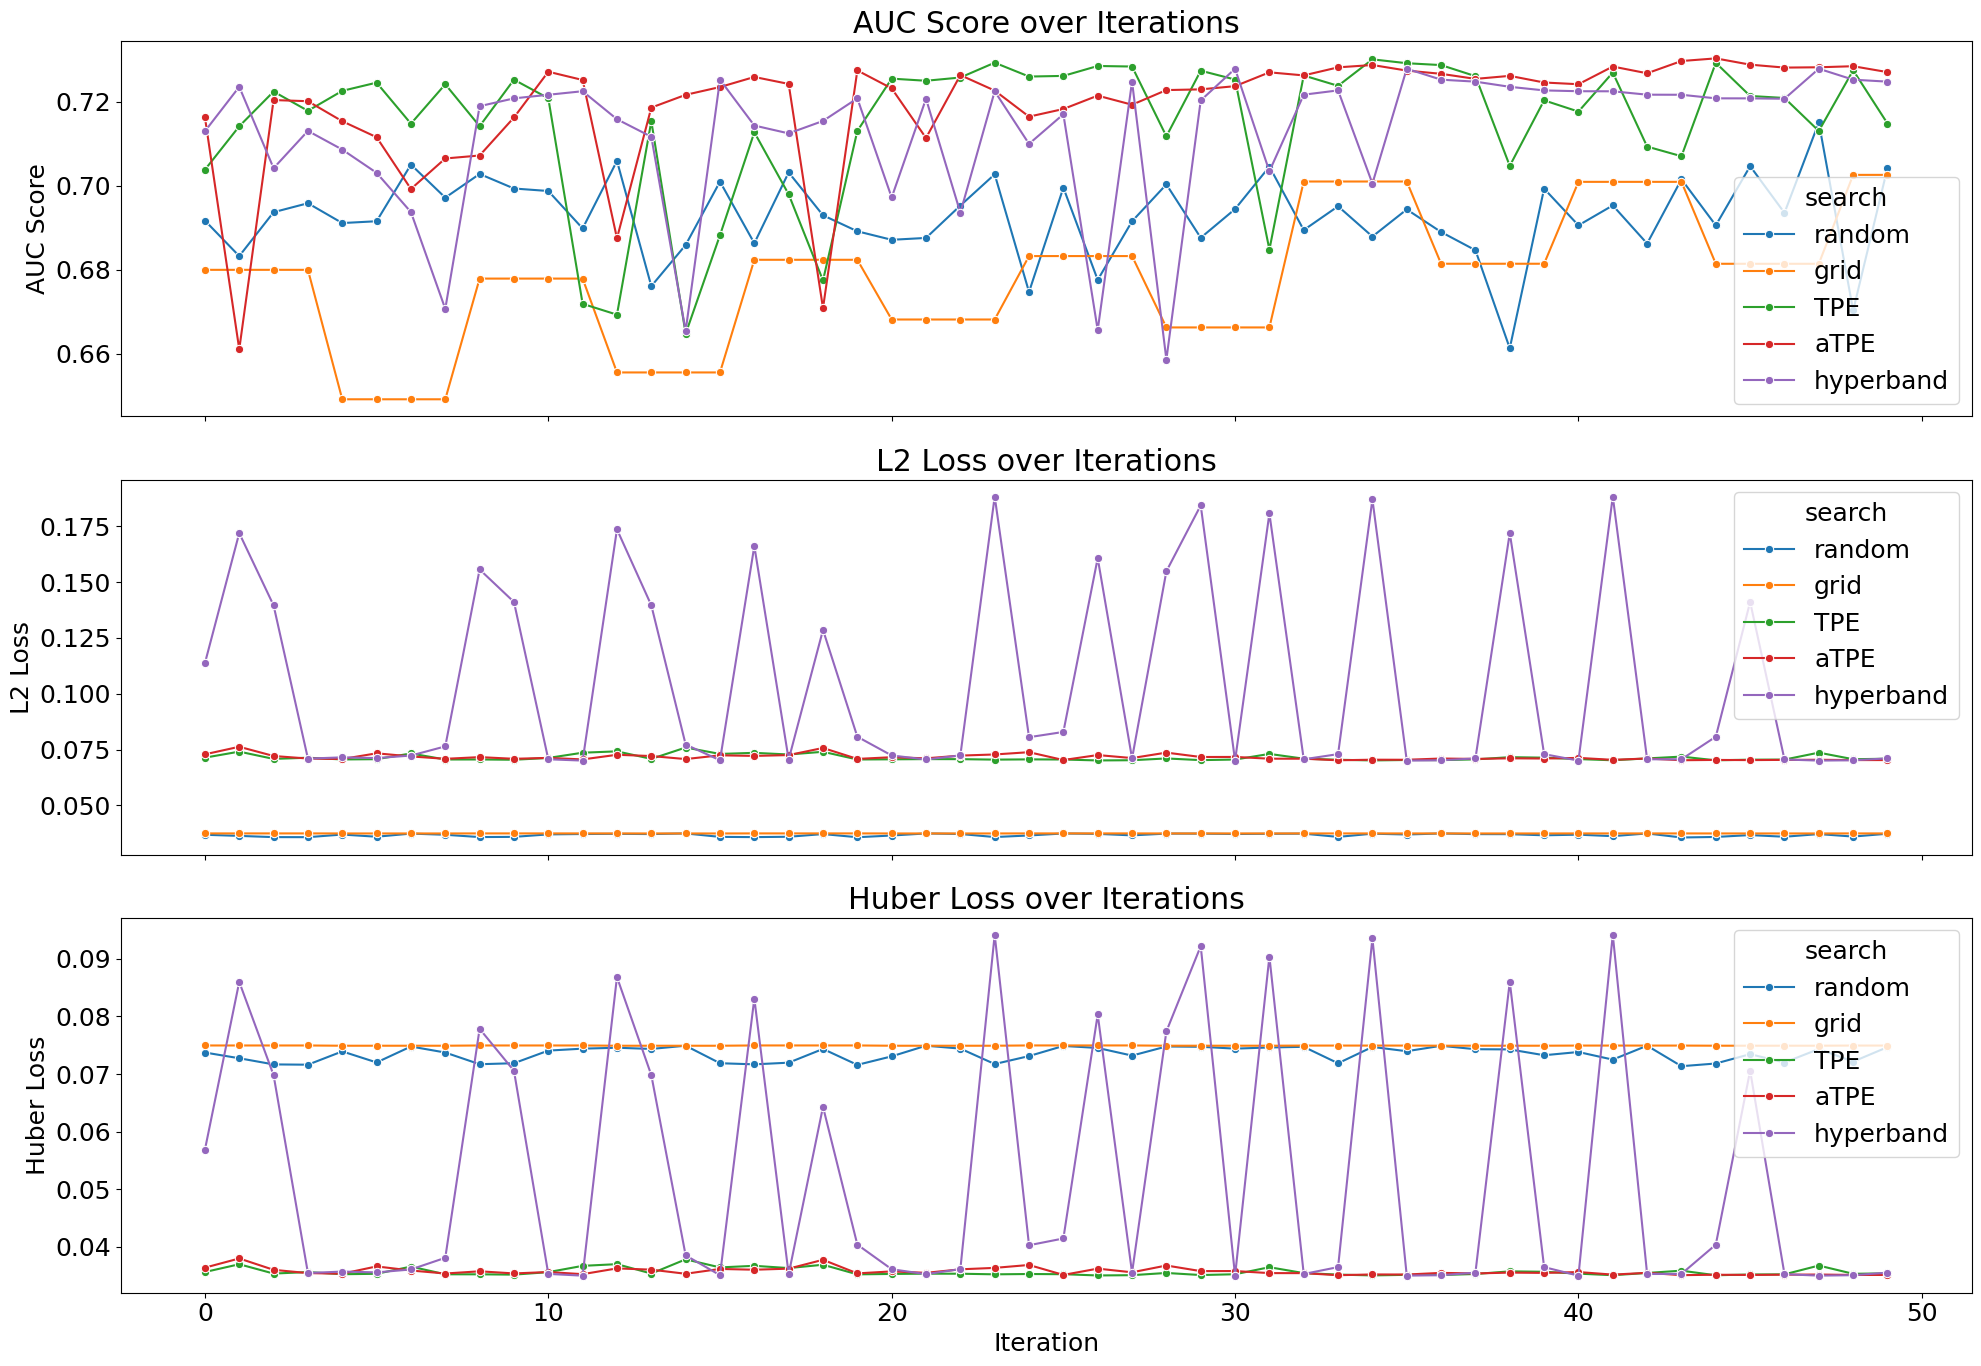

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(20, 14), sharex=True)

sns.lineplot(data=hyp, x='iteration', y='auc_score', hue='search', marker='o', ax=axes[0])
axes[0].set_title('AUC Score over Iterations')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('AUC Score')

sns.lineplot(data=hyp, x='iteration', y='l2_score', hue='search', marker='o', ax=axes[1])
axes[1].set_title('L2 Loss over Iterations')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('L2 Loss')

sns.lineplot(data=hyp, x='iteration', y='huber_score', hue='search', marker='o', ax=axes[2])
axes[2].set_title('Huber Loss over Iterations')
axes[2].set_xlabel('Iteration')
axes[2].set_ylabel('Huber Loss')

plt.tight_layout()
plt.show()

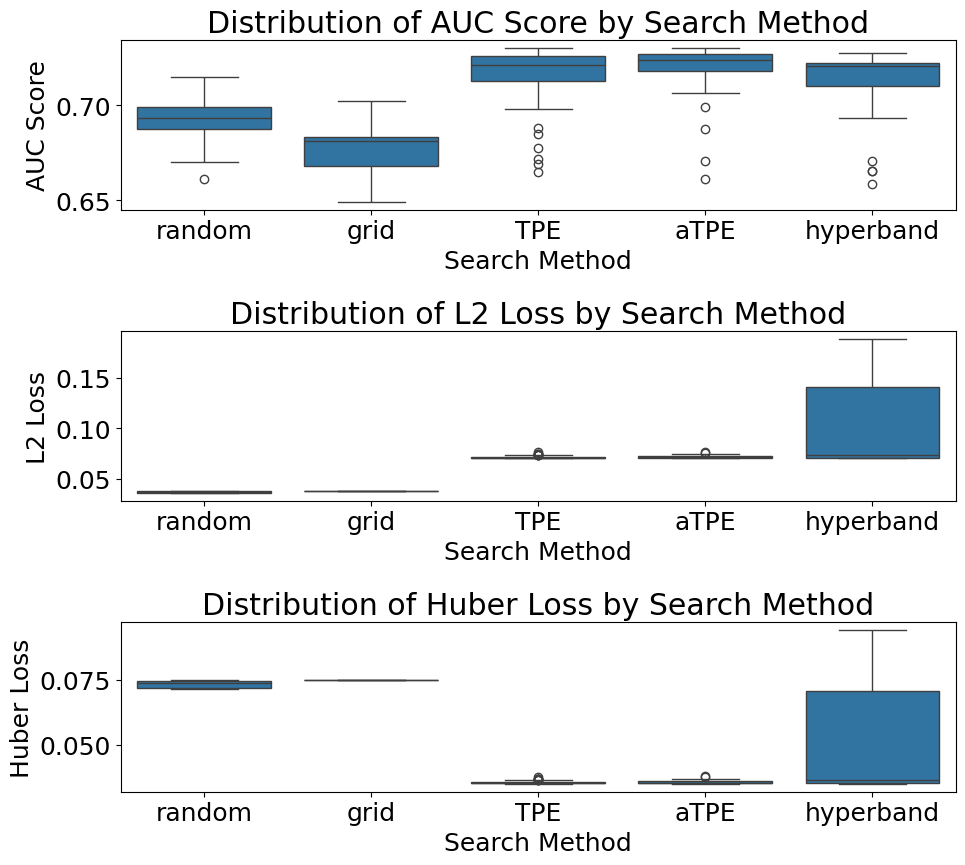

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(10, 9))

sns.boxplot(data=hyp, x='search', y='auc_score', ax=axes[0])
axes[0].set_title('Distribution of AUC Score by Search Method')
axes[0].set_xlabel('Search Method')
axes[0].set_ylabel('AUC Score')

sns.boxplot(data=hyp, x='search', y='l2_score', ax=axes[1])
axes[1].set_title('Distribution of L2 Loss by Search Method')
axes[1].set_xlabel('Search Method')
axes[1].set_ylabel('L2 Loss')

sns.boxplot(data=hyp, x='search', y='huber_score', ax=axes[2])
axes[2].set_title('Distribution of Huber Loss by Search Method')
axes[2].set_xlabel('Search Method')
axes[2].set_ylabel('Huber Loss')

plt.tight_layout()
plt.show()

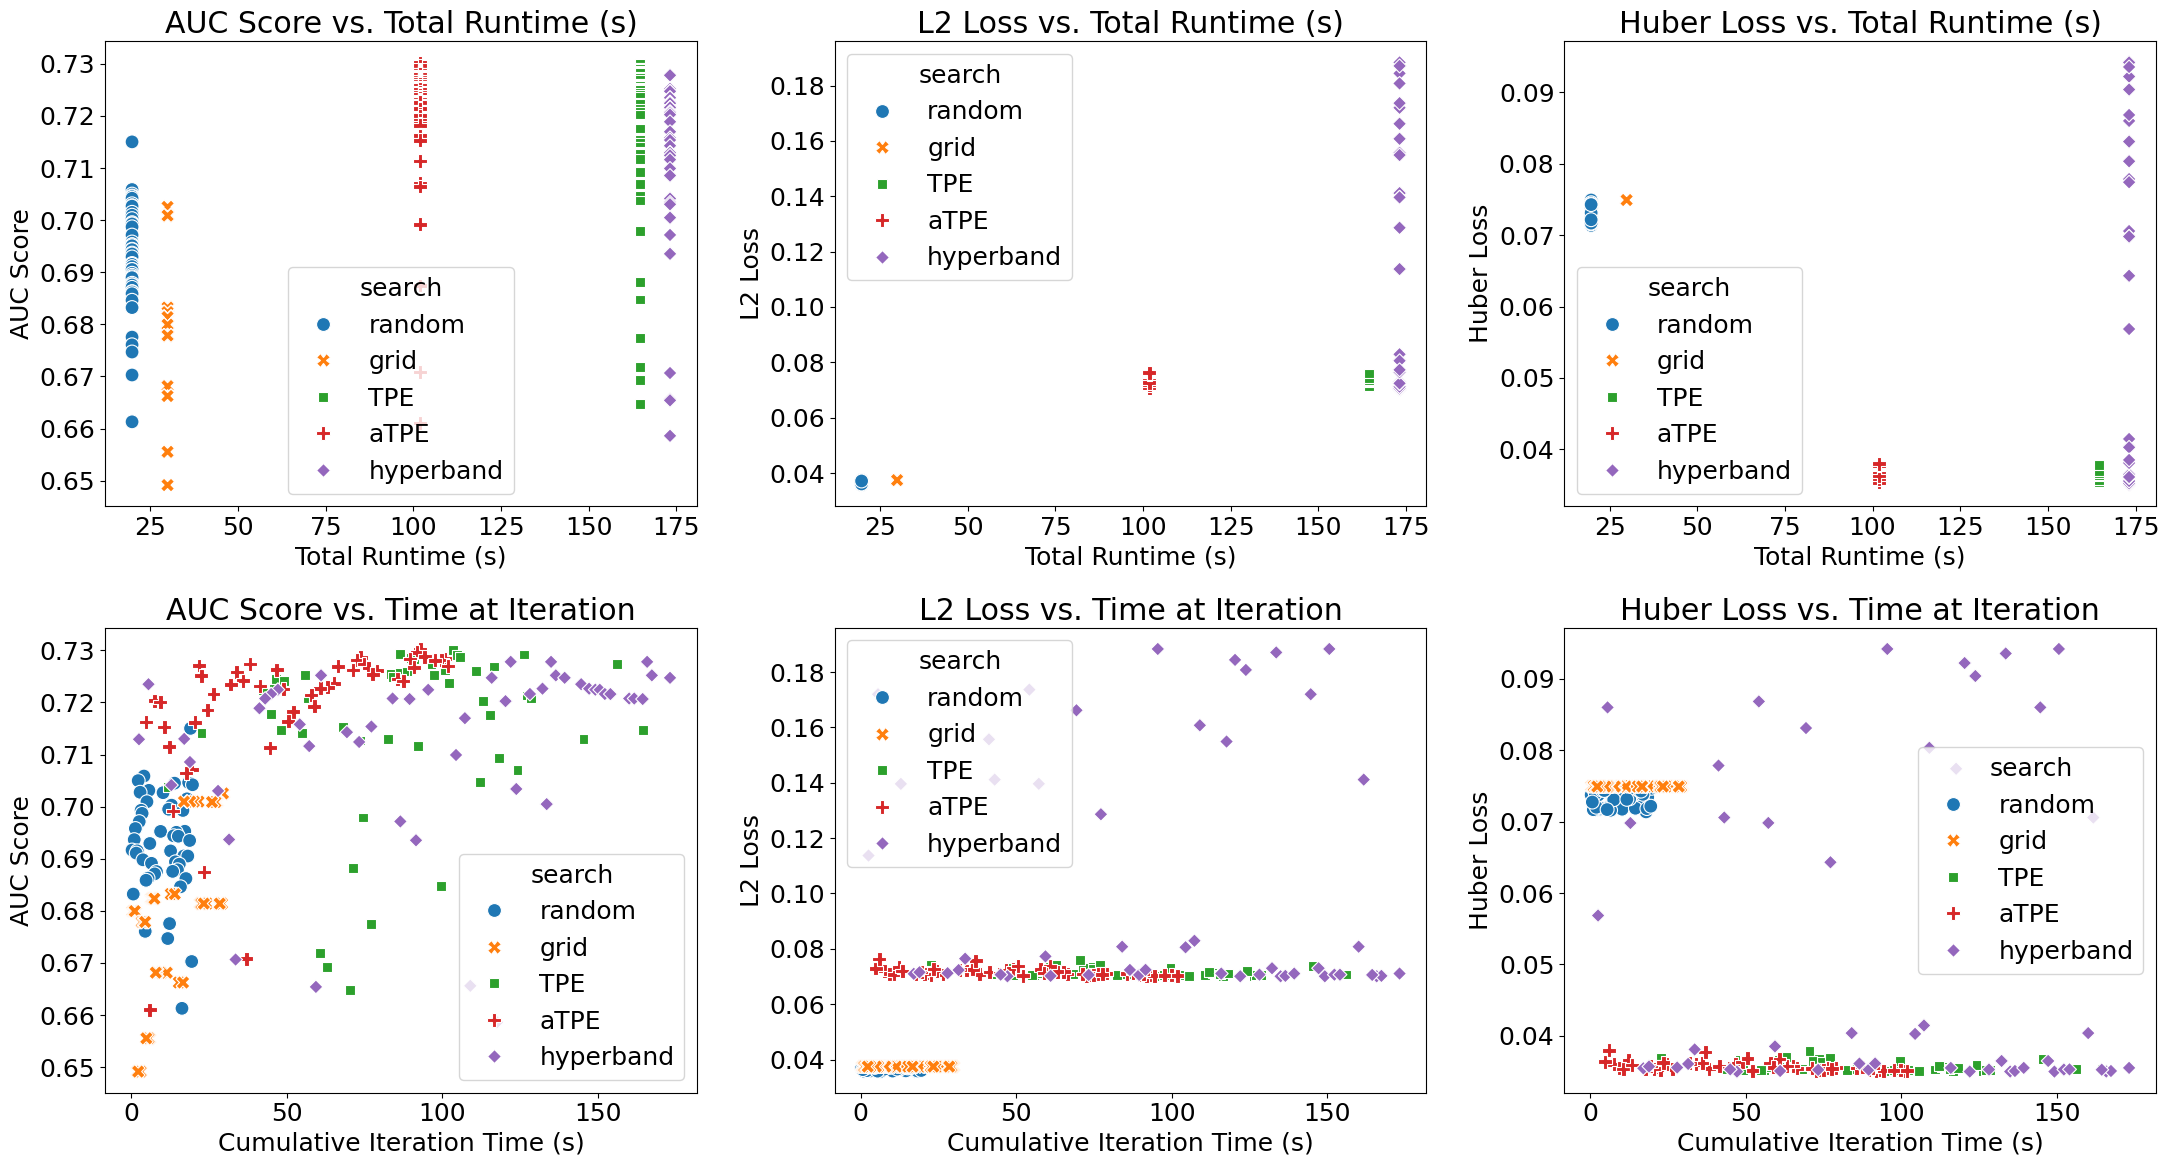

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(22, 12))

sns.scatterplot(data=hyp, x='total_runtime', y='auc_score', hue='search', style='search', s=100, ax=axes[0, 0])
axes[0, 0].set_title('AUC Score vs. Total Runtime (s)')
axes[0, 0].set_xlabel('Total Runtime (s)')
axes[0, 0].set_ylabel('AUC Score')

sns.scatterplot(data=hyp, x='total_runtime', y='l2_score', hue='search', style='search', s=100, ax=axes[0, 1])
axes[0, 1].set_title('L2 Loss vs. Total Runtime (s)')
axes[0, 1].set_xlabel('Total Runtime (s)')
axes[0, 1].set_ylabel('L2 Loss')

sns.scatterplot(data=hyp, x='total_runtime', y='huber_score', hue='search', style='search', s=100, ax=axes[0, 2])
axes[0, 2].set_title('Huber Loss vs. Total Runtime (s)')
axes[0, 2].set_xlabel('Total Runtime (s)')
axes[0, 2].set_ylabel('Huber Loss')

sns.scatterplot(data=hyp, x='time_after_iteration', y='auc_score', hue='search', style='search', s=100, ax=axes[1, 0])
axes[1, 0].set_title('AUC Score vs. Time at Iteration')
axes[1, 0].set_xlabel('Cumulative Iteration Time (s)')
axes[1, 0].set_ylabel('AUC Score')

sns.scatterplot(data=hyp, x='time_after_iteration', y='l2_score', hue='search', style='search', s=100, ax=axes[1, 1])
axes[1, 1].set_title('L2 Loss vs. Time at Iteration')
axes[1, 1].set_xlabel('Cumulative Iteration Time (s)')
axes[1, 1].set_ylabel('L2 Loss')

sns.scatterplot(data=hyp, x='time_after_iteration', y='huber_score', hue='search', style='search', s=100, ax=axes[1, 2])
axes[1, 2].set_title('Huber Loss vs. Time at Iteration')
axes[1, 2].set_xlabel('Cumulative Iteration Time (s)')
axes[1, 2].set_ylabel('Huber Loss')

plt.tight_layout()
plt.show()

## DFs with rows relating to optimal values for each metric

In [ ]:
random_results=random_hyp.copy()
grid_results = grid_hyp.copy()


grid_results['total_runtime'] = grid_results['time_after_iteration'].max()
grid_results


In [ ]:
best_random_inds = [random_hyp['auc_score'].idxmax()] + [random_hyp[loss].idxmin() for loss in ['l2_score', 'huber_score']]
best_bayes_tpe_inds = [bayes_hyp_tpe['auc_score'].idxmax()] + [bayes_hyp_tpe[loss].idxmin() for loss in ['l2_score', 'huber_score']]
best_bayes_atpe_inds = [bayes_hyp_atpe['auc_score'].idxmax()] + [bayes_hyp_atpe[loss].idxmin() for loss in ['l2_score', 'huber_score']]
best_grid_inds = [grid_hyp['auc_score'].idxmax()] + [grid_hyp[loss].idxmin() for loss in ['l2_score', 'huber_score']]

best_random_params = random_hyp.iloc[best_random_inds, :].copy()
best_bayes_tpe_params = bayes_hyp_tpe.iloc[best_bayes_tpe_inds, :].copy()
best_bayes_atpe_params = bayes_hyp_atpe.iloc[best_bayes_atpe_inds, :].copy()
best_grid_params = grid_hyp.iloc[best_grid_inds, :].copy()

hyp = pd.concat([best_random_params, best_grid_params, best_bayes_tpe_params, best_bayes_atpe_params], ignore_index=True)
hyp.head(50)

In [ ]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

sns.kdeplot(learning_rate_dist, label = 'Sampling Distribution', linewidth = 4)
sns.kdeplot(random_params['learning_rate'], label = 'Random Search', linewidth = 4)
sns.kdeplot(bayes_results['learning_rate'], label = 'Bayes Optimization', linewidth = 4)
plt.vlines([best_random_params['learning_rate'], best_bayes_params['learning_rate']],
           ymin = 0.0, ymax = 10.0, linestyles = '--', linewidth = 4, colors = ['orange', 'green'])
plt.legend()
plt.xlabel('Learning Rate'); plt.ylabel('Density'); plt.title('Learning Rate Distribution');

In [ ]:
for i, hyper in enumerate(random_params.columns):
    if hyper not in ['class_weight', 'n_estimators', 'auc_score', 'is_unbalance', 'l2_score', 'huber_score', 'runtime', 'time_after_iteration',
                    'boosting_type', 'iteration', 'subsample', 'metric', 'verbose', 'loss', 'learning_rate']:
        plt.figure(figsize = (14, 6))
        if hyper != 'loss':
            sns.kdeplot([sample(space[hyper]) for _ in range(1000)], label = 'Sampling Distribution', linewidth = 4)
        sns.kdeplot(random_params[hyper], label = 'Random Search', linewidth = 4)
        sns.kdeplot(bayes_params[hyper], label = 'Bayes Optimization', linewidth = 4)
        plt.vlines([best_random_params[hyper], best_bayes_params[hyper]],
                     ymin = 0.0, ymax = 10.0, linestyles = '--', linewidth = 4, colors = ['orange', 'green'])
        plt.legend(loc = 1)
        plt.title('{} Distribution'.format(hyper))
        plt.xlabel('{}'.format(hyper)); plt.ylabel('Density');
        plt.show();